## 04.P Geospatial Data Problem Set – Summarizing Airborne Snow Observatory Data

__Background:__ For your graduate research, you are using lidar-derived snow water equivalent (SWE) estimates to assimilate into a physics based hydrology model to make streamflow predictions. In thinking through your hypotheses portions of the landscape where SWE data will have the most impact, you are reminded of a figure you saw in a presentation at a recent meeting. The figure shows how the distribution of SWE and land area across a range of elevation interact to control the distribution of water storage in the landscape. The figure looked like the following:

<img src='../img/aso_swe.png' alt='Upper Colorado ASO Analysis' width='750' style='display: block; margin: 0 auto'/>

You already have grids of estimated SWE from the Airborne Snow Observatory (ASO) for 4 separate dates at a 50 m spatial resolution, and a coregistered digital elevation model of the study area – the East River in the Colorado Rocky Mountains.  

__Task:__ Use the skills you've developed and the example notebooks you've examined in this module to create an image like the above. The ASO and coregistered DEM can be found in [this Google Drive folder](https://drive.google.com/drive/u/0/folders/1SkjOWPPJe5N25arCW6qbf2ZJWQsrUAAp). Use any of the four ASO files, which corresponds to 2 different dates in 2018 or 2019, or write your code generically to plot any or all dates. You should only need `rasterio`, `numpy`, and `matplotlib` to create this figure.    

In [38]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

In [39]:
# import files
dates = [20180331, 20180524, 20190407, 20190610]

dem_file = '../data/aso_data/coge_dem_50m.tif'
dem = rio.open(dem_file)
dem_data = dem.read(1)


Elevation Statistics:
Number of columns [east-west]: 924 
Number of rows [north-south]: 1033
Minimum elevation: 2107.98 m
Maximum elevation: 4337.47 m
Mean elevation: 4337.47 m



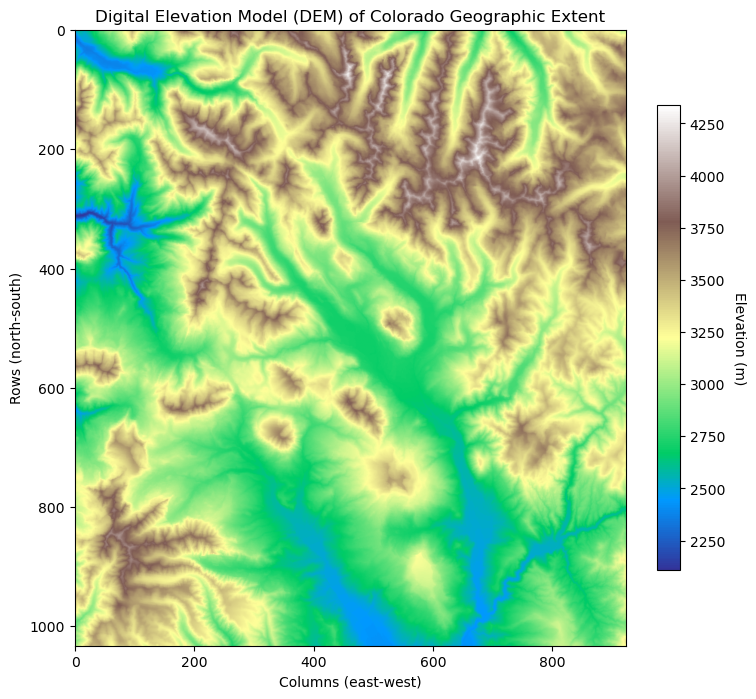

In [40]:
# elev statistics
zmin = np.nanmin(dem_data)
zmax = np.nanmax(dem_data)
zmean = np.nanmax(dem_data)

zstats = f'''
Elevation Statistics:
Number of columns [east-west]: {dem_data.shape[1]} 
Number of rows [north-south]: {dem_data.shape[0]}
Minimum elevation: {zmin:.{2}f} m
Maximum elevation: {zmax:.{2}f} m
Mean elevation: {zmean:.{2}f} m
'''
print(zstats)

# plot dem
fig, ax = plt.subplots(figsize=(10, 8))
dem_img = ax.imshow(dem_data, cmap='terrain', vmin=zmin, vmax=zmax)
cbar = fig.colorbar(dem_img, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Elevation (m)', rotation=270, labelpad=15)
ax.set_title('Digital Elevation Model (DEM) of Colorado Geographic Extent')
ax.set_xlabel('Columns (east-west)')
ax.set_ylabel('Rows (north-south)')
plt.show()


In [41]:
def swe_plot(swe, date):
    file = '../data/aso_data/ASO_50M_SWE_USCOGE_{date}.tif'.format(date=date)
    swe = rio.open(file).read(1).astype(float)

    invalid = [-9999]
    for inval in invalid:
        swe[swe == inval] = np.nan
        
    # swe statistics
    swe_min = np.nanmin(swe)
    swe_max = np.nanmax(swe)
    swe_mean = np.nanmean(swe)  
    swe_median = np.nanmedian(swe)
    swe_1std = np.nanstd(swe)

    swe_stats = f'''
    SWE Statistics:
    Minimum SWE: {swe_min:.{2}f} mm
    Maximum SWE: {swe_max:.{2}f} mm
    Mean SWE: {swe_mean:.{2}f} mm
    '''
    print(swe_stats)

    # plot swe 
    fig, ax = plt.subplots(figsize=(10, 8))
    swe_img = ax.imshow(swe, cmap='Blues', vmin=swe_min, vmax=swe_max)
    cbar = fig.colorbar(swe_img, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Snow Water Equivalent (mm)', rotation=270, labelpad=15)
    ax.set_title('Snow Water Equivalent (SWE) on {date}'.format(date=date))
    ax.set_xlabel('Columns (east-west)')
    ax.set_ylabel('Rows (north-south)')
    plt.show()

In [42]:
# for i in range(len(dates)):
#     swe_plot(swe, dates[i])

In [43]:
# making the code into a function 

def plot_swe_by_elev(date):
 
    # import files
    file = '../data/aso_data/ASO_50M_SWE_USCOGE_{date}.tif'.format(date=date)
    swe = rio.open(file).read(1).astype(float)

    dem_file = '../data/aso_data/coge_dem_50m.tif'
    dem = rio.open(dem_file)
    dem_data = dem.read(1)


    invalid = [-9999]
    for inval in invalid:
        swe[swe == inval] = np.nan

    # ------- swe plot ------
    # swe statistics
    swe_min = np.nanmin(swe)
    swe_max = np.nanmax(swe)
    swe_mean = np.nanmean(swe)  
    swe_median = np.nanmedian(swe)
    swe_1std = np.nanstd(swe)


    # ----- elev and swe plots -----
    # calculate swe mean, median, and std for each elevation
    elev_bin_height = 50  # meters
    elevation_bins = np.arange(zmin, zmax + elev_bin_height, elev_bin_height)  # 50 m bins
    elev_centers = (elevation_bins[:-1] + elevation_bins[1:]) / 2
    swe_mean_per_elev = []
    swe_median_per_elev = []
    swe_std_per_elev = []

    for i in range(len(elevation_bins) - 1):
        bin_mask = (dem_data >= elevation_bins[i]) & (dem_data < elevation_bins[i + 1])
        swe_in_bin = swe[bin_mask]
        
        swe_mean_per_elev.append(np.nanmean(swe_in_bin))
        swe_median_per_elev.append(np.nanmedian(swe_in_bin))
        swe_std_per_elev.append(np.nanstd(swe_in_bin))


    # horizontal bar plot elevation vs area 
    area_per_elev = []
    pixel_area = dem.res[0] * dem.res[1]  # in square meters

    for i in range(len(elevation_bins) - 1):
        bin_mask = (dem_data >= elevation_bins[i]) & (dem_data < elevation_bins[i + 1])
        area = np.nansum(bin_mask) * pixel_area  # total area in this elevation bin
        area_per_elev.append(area / 1e6)  # convert to square kilometers

    # horizonal bar plot elevation vs swe volume 
    swe_volume_per_elev = []
    for i in range(len(elevation_bins) - 1):
        bin_mask = (dem_data >= elevation_bins[i]) & (dem_data < elevation_bins[i + 1])
        swe_in_bin = swe[bin_mask]
        volume = np.nansum(swe_in_bin) * pixel_area / 1000  # convert mm to m³
        swe_volume_per_elev.append(volume / 1e6)  # convert to million cubic meters



    # create figure
    fig, ax = plt.subplots(1,3,figsize=(8, 6))

    # plot swe statistics vs elevation 
    ax[0].plot(swe_mean_per_elev, elev_centers,label='Mean SWE', color='blue')
    ax[0].plot(swe_median_per_elev, elev_centers,label='Median SWE', color='hotpink')

    ax[0].fill_betweenx(elev_centers, 
                    np.array(swe_mean_per_elev) - np.array(swe_std_per_elev), 
                    np.array(swe_mean_per_elev) + np.array(swe_std_per_elev), 
                    color='lightblue', alpha=0.2, label='1 Std Dev')

    ax[0].set_ylim(np.min(elev_centers), np.max(elev_centers)-elev_bin_height)
    ax[0].set_ylabel('Elevation (m)')
    ax[0].set_xlabel('Snow Water Equivalent (mm)')
    ax[0].legend()

    # horozontal bar plot elevation vs area 
    ax[1].barh(elev_centers, area_per_elev, height=elev_bin_height, color='sandybrown', alpha=0.6)
    ax[1].set_ylim(np.min(elev_centers), np.max(elev_centers)-elev_bin_height)
    ax[1].set_xlabel('Area (sq km)')
    ax[1].set_title('ASO Snow Water Storage  on {date}'.format(date=date))

    # plot horizontal bar plot elevation vs swe volume
    ax[2].barh(elev_centers, swe_volume_per_elev, height=elev_bin_height, color
    ='plum', alpha=0.6)
    ax[2].set_ylim(np.min(elev_centers), np.max(elev_centers)-elev_bin_height)
    ax[2].set_xlabel('SWE Volume (Mm³)')


    plt.tight_layout()
    plt.show()

/var/folders/hp/sps06c394_z14ng_zvbx9t_w0000gn/T/ipykernel_50809/2005817766.py:40: RuntimeWarning: Mean of empty slice
  swe_mean_per_elev.append(np.nanmean(swe_in_bin))
/var/folders/hp/sps06c394_z14ng_zvbx9t_w0000gn/T/ipykernel_50809/2005817766.py:41: RuntimeWarning: All-NaN slice encountered
  swe_median_per_elev.append(np.nanmedian(swe_in_bin))
/opt/anaconda3/envs/geos505/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


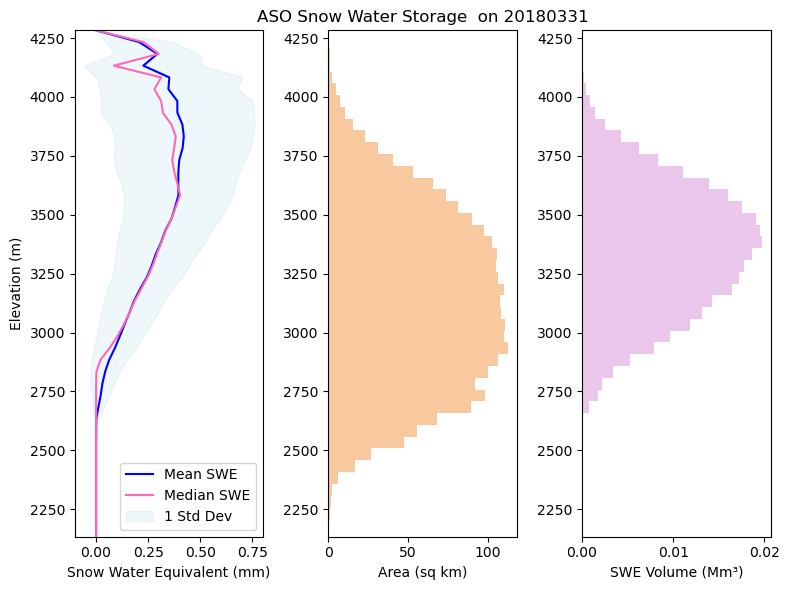

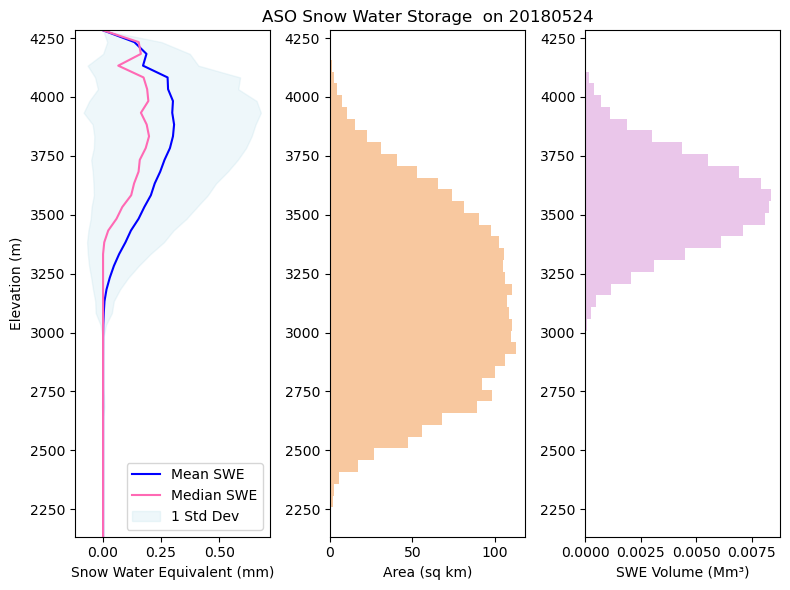

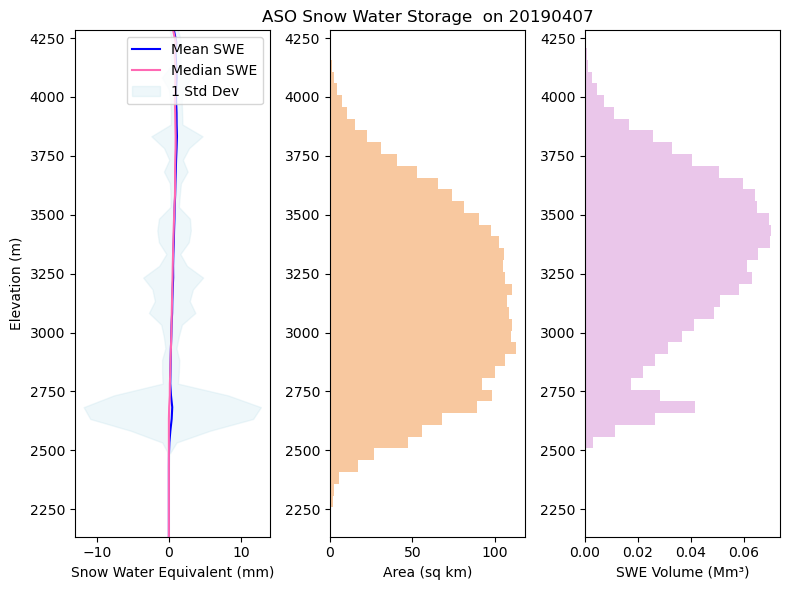

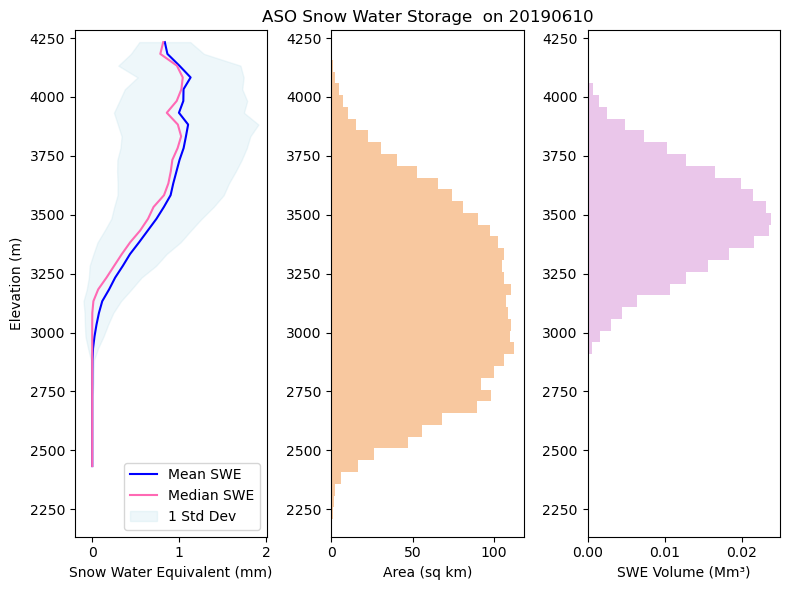

In [44]:
dates = [20180331, 20180524, 20190407, 20190610]

for i in range(len(dates)):
    plot_swe_by_elev(dates[i])